# Speech Understanding
## Assignment 3
#### Bonus Question
### Akansha Gautam (M23CSA506)

# Import libraries

In [94]:
from transformers import SpeechT5Processor, SpeechT5ForSpeechToText
from datasets import load_dataset
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from peft import get_peft_model, LoraConfig, TaskType
from datasets import Dataset
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from evaluate import load
import librosa
import pandas as pd


# Reproduce the results on any 2 datasets mentioned in the paper

## Load LibriSpeech dataset for Automatic Speech Recognition (ASR) task

In [4]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")

print(f"Dataset size: {dataset.shape}")

Dataset size: (73, 6)


## Exploratory Data Analysis

Transcript: ONLY UNFORTUNATELY HIS OWN WORK NEVER DOES GET GOOD
Audio Info: {'path': '/Users/akanshagautam/.cache/huggingface/datasets/downloads/extracted/ac4fd64e83df47fc43fb63cfcaf7cc4fb6b781851795517b2c0fe76cac15ebfc/dev_clean/1272/128104/1272-128104-0012.flac', 'array': array([-6.43920898e-03, -7.01904297e-03,  1.28173828e-03, ...,
        6.10351562e-05,  0.00000000e+00,  1.83105469e-04]), 'sampling_rate': 16000}


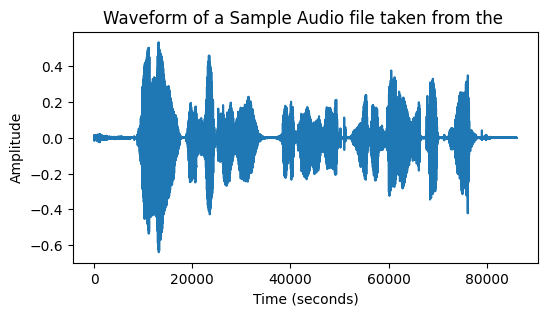

In [ ]:
# Load a sample audio file
sample1 = dataset[12]

print("Transcript:", sample1['text'])
print("Audio Info:", sample1['audio'])

plt.figure(figsize=(6,3))
plt.title(f"Waveform of a Sample Audio file taken from the ")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.plot(sample1['audio']['array'])
plt.show()

ipd.display(ipd.Audio(sample1['audio']['array'], rate=sample1['audio']['sampling_rate']))

## Load model

In [7]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_asr")
model = SpeechT5ForSpeechToText.from_pretrained("microsoft/speecht5_asr")

SpeechT5ForSpeechToText has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of SpeechT5ForSpeechToText were not initialized from the model checkpoint at microsoft/speecht5_asr and are newly initialized: ['speecht5.encod

## Generate text from LibriSpeech dataset using SpeechT5 model

In [41]:
predicted_transcriptions = []
sampling_rate = dataset.features["audio"].sampling_rate

for i in range(dataset.shape[0]):
    speech = dataset[i]["audio"]["array"]
    inputs = processor(audio=speech, sampling_rate=sampling_rate, return_tensors="pt")
    predicted_ids = model.generate(**inputs)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
    predicted_transcriptions.append(transcription)

## Calculate word-error rate (WER)

In [48]:
wer_metric = load("wer")
wer_scores = []

for i in range(len(predicted_transcriptions)):
    predicted_transcription = predicted_transcriptions[i]
    actual_transcription = [dataset[i]["text"]]
    wer_score = wer_metric.compute(predictions=predicted_transcription, references=actual_transcription)
    wer_scores.append(wer_score)

print(f"Average WER: {sum(wer_scores)/len(wer_scores)}")

Average WER: 1.0048412314931352


# Fine-tune the model with DoRA

## Load the dataset

In [71]:
# https://www.kaggle.com/datasets/mathurinache/the-lj-speech-dataset

column_names = ["file_name", "transcription", "normalized_transcription"]
metadata = pd.read_csv('/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 1/LJSpeech-1.1/metadata.csv', 
                       delimiter='|', names=column_names)
metadata['file_path'] = '/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 3/LJSpeech-1.1/wavs/' + metadata.file_name.astype(str) + '.wav'

waveforms = []
for i in range(metadata.shape[0]):
    waveform, _ = librosa.load(metadata.iloc[i]['file_path'], sr=16000)
    waveforms.append(waveform)

metadata['waveform'] = waveforms

metadata = metadata.drop(['file_name', 'transcription', 'file_path'], axis=1)
metadata.head()

,normalized_transcription,waveform
0,"Printing, in the only sense with which we are ...","[-0.00061750744, -0.0007449561, -0.0006897191,..."
1,in being comparatively modern.,"[-0.00019426376, 1.0826876e-05, -7.1500086e-05..."
2,For although the Chinese took impressions from...,"[-0.0040418175, -0.0003124748, -0.001588953, -..."
3,"produced the block books, which were the immed...","[0.00018425738, -6.8946814e-05, -0.00024377496..."
4,the invention of movable metal letters in the ...,"[0.00032222396, 0.00043797283, 0.00043948228, ..."


In [92]:
train_df, test_df = train_test_split(metadata, test_size=0.1, random_state=42)

train_df = train_df.reset_index(drop=True).iloc[:50]
test_df = test_df.reset_index(drop=True).iloc[:10]

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def preprocess(example):
    audio_inputs = processor(
        audio=example["waveform"],
        sampling_rate=16000,
        return_tensors="pt"
    )
    text_labels = processor.tokenizer(
        example["normalized_transcription"],
        return_tensors="pt"
    )

    return {
        "input_values": audio_inputs.input_values[0],
        "labels": text_labels.input_ids[0]
    }

train_dataset = train_dataset.map(preprocess, remove_columns=["waveform", "normalized_transcription"])
test_dataset = test_dataset.map(preprocess, remove_columns=["waveform", "normalized_transcription"])

print("Train Dataset Size:", len(train_dataset))
print("Test Dataset Size:", len(test_dataset))


Map: 100%|██████████| 10/10 [00:00<00:00, 46.19 examples/s]

Train Dataset Size: 50
Test Dataset Size: 10


## Fine-tune the model with DoRA

In [96]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_asr")
model = SpeechT5ForSpeechToText.from_pretrained("microsoft/speecht5_asr")

peft_config = LoraConfig(task_type=TaskType.CAUSAL_LM, r=4, lora_alpha=16, lora_dropout=0.1, use_dora=True, target_modules=["q_proj", "v_proj"])

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

Some weights of SpeechT5ForSpeechToText were not initialized from the model checkpoint at microsoft/speecht5_asr and are newly initialized: ['speecht5.encoder.prenet.pos_sinusoidal_embed.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 331,776 || all params: 154,920,576 || trainable%: 0.2142


In [95]:
training_args = TrainingArguments(
    output_dir="/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 3/FineTunedModelOutput",
    per_device_train_batch_size=2, num_train_epochs=5, logging_steps=10, save_steps=200, evaluation_strategy="epoch", fp16=False, bf16=False, no_cuda=True
)

data_collator = DataCollatorWithPadding(
    processor=processor,padding=True,return_tensors="pt"
)

trainer = Trainer(model=model,args=training_args,train_dataset=train_dataset, eval_dataset=test_dataset, data_collator=data_collator)

trainer.train()

TypeError: __init__() got an unexpected keyword argument 'processor'

In [ ]:
import torch
from evaluate import load

wer_metric = load("wer")

def compute_wer(model, processor, dataset):
    model.eval()
    predictions, references = [], []

    for sample in dataset:
        input_tensor = torch.tensor(sample["input_values"]).unsqueeze(0)
        with torch.no_grad():
            pred_ids = model.generate(input_tensor)
        pred_text = processor.batch_decode(pred_ids, skip_special_tokens=True)[0].lower()

        label_text = processor.tokenizer.decode(sample["labels"], skip_special_tokens=True).lower()
        predictions.append(pred_text)
        references.append(label_text)

    return wer_metric.compute(predictions=predictions, references=references)

# Run evaluation
wer = compute_wer(model, processor, test_dataset)
print(f"WER on test set: {wer:.3f}")
